# Constant Proportion Portfolio Insurance - CPPI
Estratégia baseada na alocação dinâmica entre um ativo de risco (ações, criptos) e um ativo de segurança (tesouro, ETFs). A alocação no ativo de risco deve respeitar a diferença (chamada de *cushion*) entre o capital do investidor (*wealth*), um dado mínimo (*floor*) e um multiplicador de agressividade $m$. Por exemplo, dado que o investidor possui \$ 100, estabelece um floor de 80% e uma agressividade $m=3$, a alocação no ativo de risco seria de $3 \times (100 - 80) = 60$. Como consequência, o investimento no ativo de segurança seria de \$ 40.

Teoricamente, o floor sempre pode ser evitado se o investidor operar frequentemente em uma política não muito agressiva e o ativo de risco não possuir uma volatilidade muito elevada. O risco de ultrapassá-lo é conhecido como *gap risk*.

**Extensão - Maximum Drawdown Constraint**

Uma extensão da estratégia consiste em incluir restrições a drawdowns, *i.e.*, manter o drawdown máximo abaixo de um certo limite. Assume que o valor do portfólio num tempo $t$ dá-se por $V_t$ e desejamos evitar situações onde podemos perder mais que 20% do mesmo. Alcançamos este objetivo introduzindo o valor máximo do portfólio $M_t > 0$ entre $t=0$ e $t=1$, tal que $$V_t > (1 - 0.2) M_t.$$

**Extensão - Performance CAP**

Com o lower bound especificado (floor ou max. drawdown), podemos adicionar um controle extra ao investimento de risco inserindo um upper bound (CAP): o máximo que o investidor espera atingir no investimento. Estas restrições custam ao investidor eventuais lucros (upside risk), com o prêmio de protegê-lo de downside risk. Lembrando que esta é uma estratégia de segurança, não de lucros.

Sendo

- $F_t$: floor (valor mínimo de wealth a proteger)
- $C_t$: cap (valor máximo de wealth a proteger)
- $A_t$: valor do portfólio (account value)
- $E_t$: quantidade de risco (valor a ser investido no ativo de risco)
- $T_t$: threshold level que determina o valor em que a proteção de downside risk torna-se proteção de upside risk,
temos $$F_t \leqslant A_t \leqslant T_t \Rightarrow E_t = M_t (A_t - F_t),$$ e $$T_t \leqslant A_t \leqslant C_t \Rightarrow E_t = M_t (C_t - A_t).$$ Isto é, se o valor do portfólio estiver entre o floor e o threshold level, estaremos realizando uma proteção de downside e, se o valor do portfólio estiver entre o threshold level e o cap, estaremos realizando uma proteção de upside. O valor do threshold é determinado exigindo que a quantidade de risco seja a mesma na transição e notando que $A_t = T_t$: $$E_t = M_t(T_t - F_t) = M_t(C_t - T_t) \ \Rightarrow \ T_t = \frac{F_t - C_t}{2}.$$

Por exemplo, dado que nosso capital (wealth) seja de \$ 100, a alocação no investimento de risco, com $M_t = 4$, um floor de 90% e um CAP de 105% dá-se por $4 \times (105\% - 100\%) = 20\% $, dado que estamos mais próximos do CAP que do floor. Neste caso, encontramos $T_t = (90\% + 105\%) / 2 = 97.5\% $.

A estratégia então consiste em determinarmos um nível de agressividade (multiplicador), nosso floor (e cap, se desejar) e o drawdown máximo. Dado um investimento inicial (wealth) e o floor, podemos computar o cushion e, assim, determinar quanto será alocado nos ativos de risco. A cada intervalo de tempo (semanal ou mensal, por exemplo) reavaliamos o cushion e realocamos os pesos.

Perceba que o multiplicador está fortemente atrelado à volatilidade do ativo de risco e o período de tempo considerado (de realocação), ou seja, há um trade-off entre eles. Para ativos muito voláteis, podemos acompanhá-lo com um período menor, mantendo o multiplicador constante, ou vice-versa. Isto pode ser vista através da pergunta: dado que uma queda $d$ (em %) ocorreu (volatilidade) num determinado intervalo de tempo (período de realocação), qual o valor máximo de $m$ que não viola o floor? Basicamente, procuramos $$A - dE \geqslant F.$$ Lembrando que $E = m(A - F),$ chegamos em $m \leqslant 1/d.$ Ou seja, para evitarmos uma queda de 20%, o valor máximo de $m$ deve ser $m=5$.

#### Portfolio

- Ativos de risco: SP500 e Bitcoin
- Ativo de segurança: IMAB

Intervalo de tempo considerado: diário.

In [1]:
import pandas as pd
import numpy as np
import quant_tools as qt                        # módulo de funções quants auxiliares
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import visuals                                  # módulo de visualização pessoal
from portfolio_class import Portfolio           # classe auxiliar

In [2]:
start_past_dt = dt(2017, 11, 10)
end_past_dt = dt(2022, 1, 1)

sp500_past = Portfolio(
    'SPXI11',
    ['SPXI11'],
    start_past_dt,
    end_past_dt,
    source='yf'
)

btc_past = Portfolio(
    'BTC',
    ['BTC-USD'],
    start_past_dt,
    end_past_dt,
    source='yf',
    crypto=True
)

imab_past_pr = qt.get_quandl('imab', start_past_dt, end_past_dt)
imab_past = Portfolio('IMAB', ['IMAB'])
imab_past.prices = imab_past_pr
imab_past.dates = (start_past_dt, end_past_dt)
Portfolio.register(imab_past)

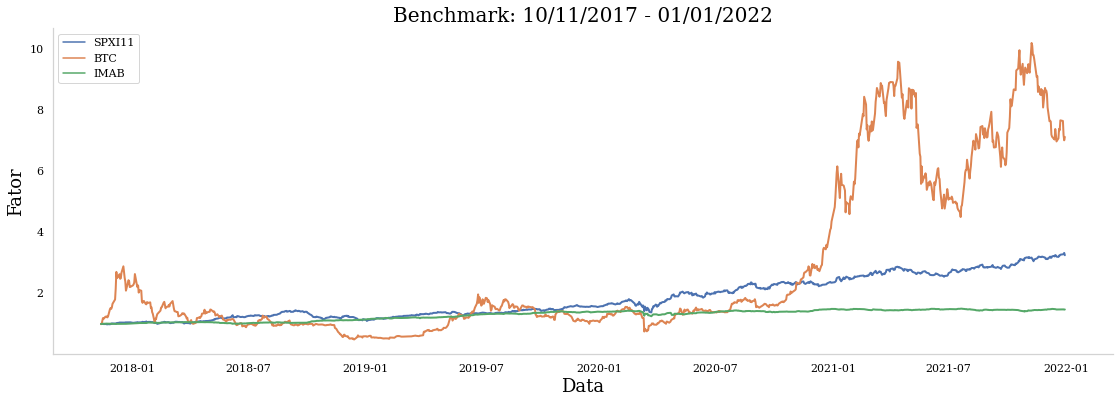

In [72]:
sp500_past.benchmark([btc_past, imab_past])

- Ativo de Risco: 90% SP500 e 10% BTC

In [3]:
risky_p = sp500_past + btc_past
risky_p.name = 'Risky'
risky_p.weights = np.array([.9, .1])
Portfolio.unregister(sp500_past.name + ' + ' + btc_past.name)
risky_p.prices

,SPXI11,BTC-USD
Date,,
2017-11-10,87.199997,6618.140137
2017-11-13,87.150002,6559.490234
2017-11-14,87.150002,6635.750000
2017-11-16,87.500000,7871.689941
2017-11-17,86.800003,7708.990234
...,...,...
2021-12-23,285.000000,50784.539062
2021-12-27,286.130005,50640.417969
2021-12-28,286.489990,47588.855469


In [42]:
risky_p.volatility(is_portfolio=False)

,SPXI11,BTC-USD
Diária,0.014209,0.049449
Mensal,0.065114,0.226604
Anual,0.225560,0.784980


### Floor Constante de 90%

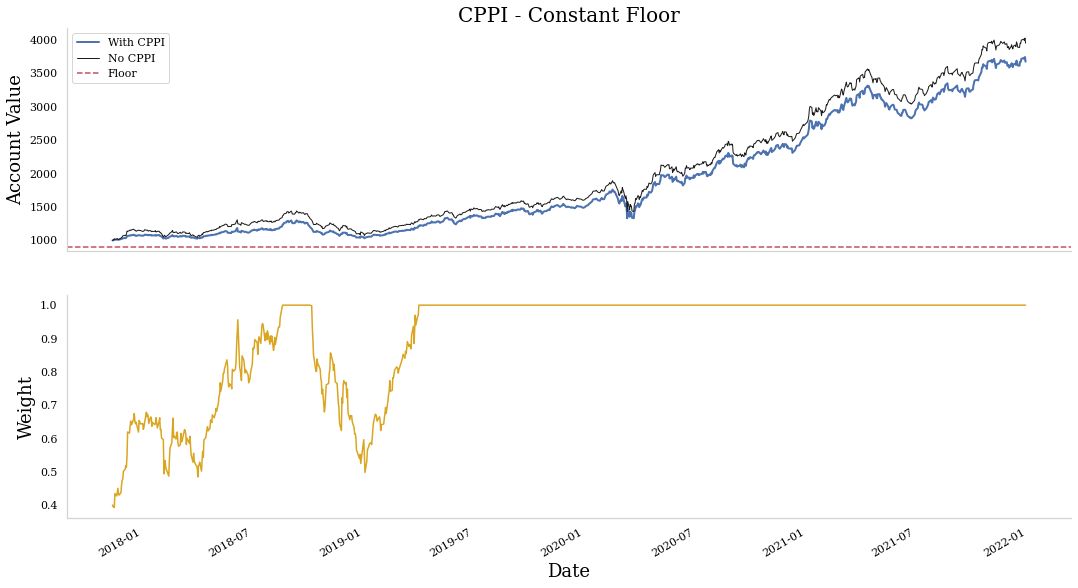

In [57]:
btr = qt.run_cppi(risky_p.d_returns(), imab_past.d_returns(), m=4, floor=.9)

fig, (cppi_ax, weight_ax) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 10)
)
plt.subplots_adjust(wspace=.0)

# cppi
btr['wealth'].plot(ax=cppi_ax, linewidth=2, label='With CPPI')
btr['risky_wealth'].plot(ax=cppi_ax, linewidth=1, color='k', label='No CPPI')
cppi_ax.axhline(y=btr['floor'], color='r', linestyle='--', label='Floor')
cppi_ax.set_title('CPPI - Constant Floor')
cppi_ax.legend()
cppi_ax.set_ylabel('Account Value')

# evolução do peso
btr['risky_allocation'].plot(ax=weight_ax, color='goldenrod')
weight_ax.set_ylabel('Weight');

In [52]:
r1 = btr['risky_wealth'].pct_change().dropna()
r2 = btr['wealth'].pct_change().dropna()

pd.DataFrame({
    'No CPPI': [
        r1.std() * np.sqrt(21),
        r1.std() * np.sqrt(252),
        qt.max_drawdown(r1),
        btr['risky_wealth'].iloc[-1]
    ],
    'CPPI': [
        r2.std() * np.sqrt(21),
        r2.std() * np.sqrt(252),
        qt.max_drawdown(r2),
        btr['wealth'].iloc[-1]
    ]
}, index=['Mensal', 'Anual', 'Max. Drawdown', 'Final Asset Value']).T

,Mensal,Anual,Max. Drawdown,Final Asset Value
No CPPI,0.065392,0.226524,-0.255668,3943.882907
CPPI,0.061763,0.213955,-0.244050,3666.751503


Observe que, como o asset value esteve próximo do floor entre 01/2018 e 07/2019, a realocação ocorreu com frequência, indo de 40% no ativo de risco até 100%. No momento de maior queda, em 01/2019, seu peso foi de 100% para 50%, onde notamos uma variação menos abrupta do portfólio com CPPI (linha azul). A partir de 07/2019 vemos que o asset value afasta-se do floor, devido à alavancagem dos ativos, e o CPPI mantém o peso de risco em 100%.

Perceba como manter o floor constante somente previne os drawdowns quando o asset value está próximo deste, assim não alterando de forma significativa a volatilidade e o drawdown máximo. Por isso também é interessante avaliarmos uma estratégia com floor dinâmico.

### Floor Dinâmico - Drawdown de 20%

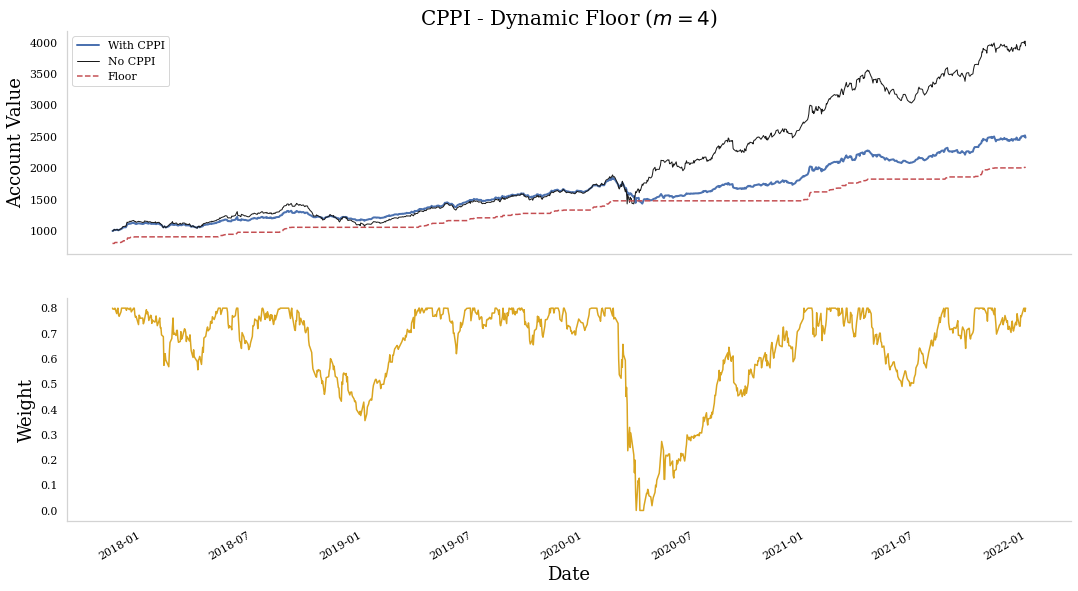

In [58]:
btr = qt.run_cppi(risky_p.d_returns(), imab_past.d_returns(), m=4, drawdown=.2)

fig, (cppi_ax, weight_ax) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 10)
)
plt.subplots_adjust(wspace=.0)

# cppi
btr['wealth'].plot(ax=cppi_ax, linewidth=2, label='With CPPI')
btr['risky_wealth'].plot(ax=cppi_ax, linewidth=1, color='k', label='No CPPI')
btr['floor'].plot(ax=cppi_ax, color='r', linestyle='--', label='Floor')
cppi_ax.set_title(r'CPPI - Dynamic Floor ($m = 4$)')
cppi_ax.legend()
cppi_ax.set_ylabel('Account Value')

# evolução do peso
btr['risky_allocation'].plot(ax=weight_ax, color='goldenrod')
weight_ax.set_ylabel('Weight');

In [54]:
r1 = btr['risky_wealth'].pct_change().dropna()
r2 = btr['wealth'].pct_change().dropna()

pd.DataFrame({
    'No CPPI': [
        r1.std() * np.sqrt(21),
        r1.std() * np.sqrt(252),
        qt.max_drawdown(r1),
        btr['risky_wealth'].iloc[-1]
    ],
    'CPPI': [
        r2.std() * np.sqrt(21),
        r2.std() * np.sqrt(252),
        qt.max_drawdown(r2),
        btr['wealth'].iloc[-1]
    ]
}, index=['Mensal', 'Anual', 'Max. Drawdown', 'Final Asset Value']).T

,Mensal,Anual,Max. Drawdown,Final Asset Value
No CPPI,0.065392,0.226524,-0.255668,3943.882907
CPPI,0.040520,0.140365,-0.223965,2483.212890


Para este caso, a realocação dos pesos ocorre durante todo o período considerado, indo de 0% até 80%. No entanto, mesmo com a estratégia, não foi capaz de previnir um drawdown maior que 20%, devido à alta volatilidade do BTC, mesmo diária. De qualquer forma, o portfólio sem CPPI ultrapassou o floor em dois momentos: 01/2019 e entre 01/2020 e 07/2020, enquanto o portfólio com CPPI somente o cruzou nesta última data.

Neste cenário é possível ver um abatimento maior da volatilidade, caindo de 22.7% para 14.0% (anual), ao custo de upside. Se considerarmos um período maior de tempo para reavaliação como, *e.g.*, semanalmente, é esperado encontrarmos mais violações.

Como a volatilidade do BTC é muito elevada, uma tentativa para amenizar as violações é diminuir o multiplicador, *i.e.*, expôr-se menos ao ativo de risco.

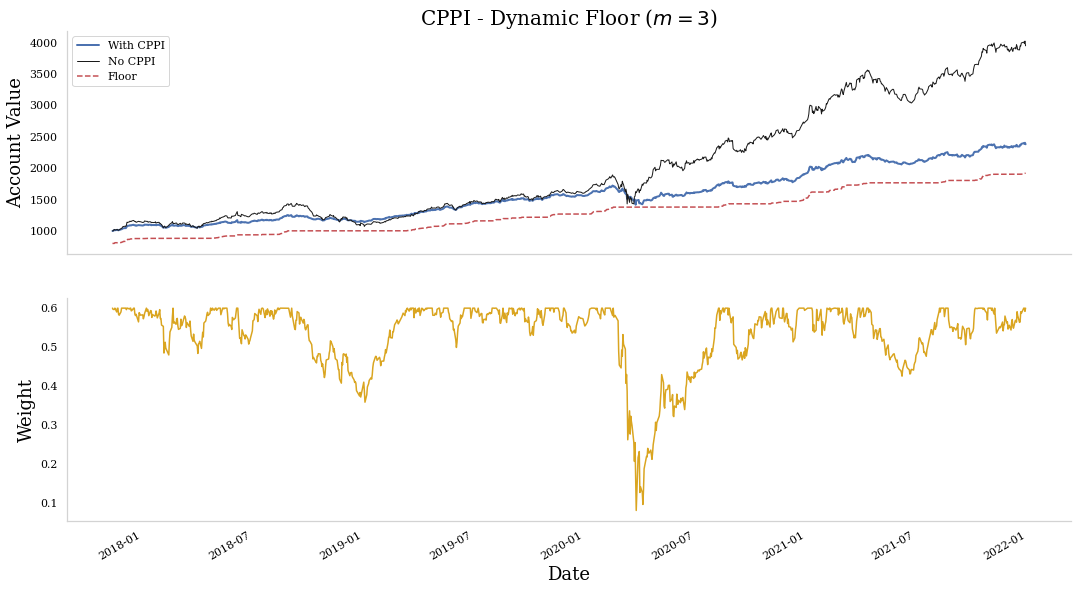

In [59]:
btr = qt.run_cppi(risky_p.d_returns(), imab_past.d_returns(), m=3, drawdown=.2)

fig, (cppi_ax, weight_ax) = plt.subplots(
    nrows=2, ncols=1, sharex=True,
    figsize=(18, 10)
)
plt.subplots_adjust(wspace=.0)

# cppi
btr['wealth'].plot(ax=cppi_ax, linewidth=2, label='With CPPI')
btr['risky_wealth'].plot(ax=cppi_ax, linewidth=1, color='k', label='No CPPI')
btr['floor'].plot(ax=cppi_ax, color='r', linestyle='--', label='Floor')
cppi_ax.set_title(r'CPPI - Dynamic Floor ($m = 3$)')
cppi_ax.legend()
cppi_ax.set_ylabel('Account Value')

# evolução do peso
btr['risky_allocation'].plot(ax=weight_ax, color='goldenrod')
weight_ax.set_ylabel('Weight');

In [56]:
r1 = btr['risky_wealth'].pct_change().dropna()
r2 = btr['wealth'].pct_change().dropna()

pd.DataFrame({
    'No CPPI': [
        r1.std() * np.sqrt(21),
        r1.std() * np.sqrt(252),
        qt.max_drawdown(r1),
        btr['risky_wealth'].iloc[-1]
    ],
    'CPPI': [
        r2.std() * np.sqrt(21),
        r2.std() * np.sqrt(252),
        qt.max_drawdown(r2),
        btr['wealth'].iloc[-1]
    ]
}, index=['Mensal', 'Anual', 'Max. Drawdown', 'Final Asset Value']).T

,Mensal,Anual,Max. Drawdown,Final Asset Value
No CPPI,0.065392,0.226524,-0.255668,3943.882907
CPPI,0.034461,0.119375,-0.177961,2377.657569


Para este caso observamos que nenhum portfolio viola o floor, e uma redução considerável da volatilidade e do drawdown máximo.